## improved_from_PredictiveIntelligenceLab_physics-informed.ipynb

The forward problem is based on Poisson equation, and the map of interest is the one that takes Dirichlet boundary condition function to the solution of the PDE. The dmain is a triangular with a notch. The numerical solution and the implementation in Matlab is from the repository [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main).

> For the implementation, we only need `Darcy_Triangulation.mat` which is included in the repository. 

> Dependencies can be installed using `neuralop.yml` file in the root directory of this repository. 

Notebook implements DeepONet following [Physics-informed-DeepONets](https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/tree/main) library. This is based on `jax`. The original implementation is buggy and data intensive. It needs data in the form of $(N*P) \times M$ for branch input, $(N*P)\times 2$ for trunk input, and $(N*P) \times 1$ for output, where
- $N$ - Number of input functions
- $M$ - Number of elements in one input function (number of nodal values after the discretization of input function)
- $P$ - Number of spatial points in 2D at which the output function is evaluated. 
In our case, $N = 1900$ = number of training input functions, $M = 101$ = elements in discretization of one input function, and $P=2397$ = nodes in the finite element mesh of the domain which are also used as spatial locations to evaluate the output function. With these numbers, the size of data is pretty large. The workstation with 64 Gb ram could not handle the code, and could not finish even a single optimization step.

In the current implementation, we use the data as in the first two implementation, and the code is quite fast in training and memory efficient. 

In [1]:
import sys
import os
import time

import numpy as np
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import trange
import matplotlib.pyplot as plt

import scipy.io as io

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
data_folder = 'data/'
result_folder = 'Results_third_method/'
current_directory = os.getcwd()  
save_results_to = current_directory + '/' + result_folder
if not os.path.exists(save_results_to):
    os.makedirs(save_results_to)

## Utilities function

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    n1, n2 = len(fn_nodal_values), 1
    if fn_nodal_values.ndim == 2:
        n2 = fn_nodal_values.shape[1]
    elif fn_nodal_values.ndim > 2: 
        raise ValueError("fn_nodal_values should be a 1D or 2D array")

    if n1 != nodes.shape[0]:
        raise ValueError("Number of nodes in the mesh and the number of dofs do not match")
    
    # Compute magnitude of the field
    C = None
    if fn_nodal_values.ndim == 1:
        C = fn_nodal_values[:]**2
    else:
        for i in range(n2):
            if i == 0:
                C = fn_nodal_values[:, i]**2
            else:
                C += fn_nodal_values[:, i]**2

    C = np.sqrt(C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, C, shading=shading, **kwargs)

    return cbar

## Define network methods

In [4]:
class DataEncoderDecoder:
    def __init__(self, mean, std, tol = 1.0e-9):
        self.mean = mean
        self.std = std
        self.tol = tol

    def encoder(self, x):
        
        x = (x - self.mean)/(self.std + self.tol)
        return x   
    
    def decoder(self, x):
        
        x = x*(self.std + self.tol) + self.mean
        return x

In [5]:
class Datahandler(Dataset):
    def __init__(self, x_branch_, x_trunk_, y_):

        # x_branch = self.convert_np_to_tensor(x_branch_)
        # x_trunk = self.convert_np_to_tensor(x_trunk_)
        # y = self.convert_np_to_tensor(y_)

        self.x_batch = x_branch_
        self.x_trunk = x_trunk_
        self.y = y_

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.y)  # Assuming x_batch and x_trunk have the same length as y

    def __getitem__(self, index):
        return self.x_batch[index,:], self.x_trunk, self.y[index,:]

### MLP and Network classes

In [6]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

In [7]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers, lr = 1.e-3):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(lr, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()
        # Logger
        self.train_loss_log = []
        self.test_loss_log = []

    # Define opeartor net
    def operator_net(self, params, branch_inp, trunk_inp):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, branch_inp)
        T = self.trunk_apply(trunk_params, trunk_inp)
        outputs = jnp.dot(B, T.T)
        # print('B shape: {}, T shape: {}, outputs shape: {}'.format(B.shape, T.shape, outputs.shape))
        return outputs
    
    # Define operator loss
    def loss_operator(self, params, batch):
        branch_inp = batch['branch_inp']
        trunk_inp = batch['trunk_inp']
        y_out = batch['y_out']
        
        # Compute forward pass
        # s_pred = vmap(self.operator_net, (None, 0, 0))(params, branch_inp, trunk_inp)
        s_pred = self.operator_net(params, branch_inp, trunk_inp)
        
        # Compute y_out
        loss = jnp.mean((y_out.flatten() - s_pred.flatten())**2)
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_operator)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, train_data, test_data, batch_size=32, epochs=100, \
              log=True, loss_print_freq = 100):

        self.epochs = epochs
        self.batch_size = batch_size

        dataset = Datahandler(train_data['branch_inp'], \
                              train_data['trunk_inp'], train_data['y_out'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        trunk_inp = dataset.x_trunk

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))
        
        # Main training loop
        for epoch in range(epochs):

            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for branch_inp, _, y_out in dataloader:
                branch_inp = branch_inp.numpy()
                y_out = y_out.numpy()

                # print(branch_inp.shape, trunk_inp.shape, y_out.shape)

                batch = {'branch_inp': branch_inp, 'trunk_inp': trunk_inp, 'y_out': y_out}

                self.opt_state = self.step(next(self.itercount), \
                                           self.opt_state, batch)
                
                # train loss
                params = self.get_params(self.opt_state)
                train_losses.append(self.loss_operator(params, batch))

                # test loss
                test_losses.append(self.loss_operator(params, test_data))

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True and epoch % loss_print_freq == 0:
                print('='*30)
                print('Epoch: {:5d}, Train Loss (rel l2): {:.3e}, Test Loss (rel l2): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, branch_inp, trunk_inp):
        s_pred = self.operator_net(params, branch_inp, trunk_inp)
        return s_pred
    
    def predict(self, test_data):
        branch_inp = test_data['branch_inp']
        trunk_inp = test_data['trunk_inp']
        y_out = test_data['y_out']

        params = self.get_params(self.opt_state)
        y_pred = self.operator_net(params, branch_inp, trunk_inp)

        return y_pred

## Process data

In [8]:
def process_data(num_train, num_test, inp_grid_points, out_grid_points):
    
    data = io.loadmat(data_folder + 'Darcy_Triangular')
    
    xx = data['xx']
    yy = data['yy']
    xx = np.reshape(xx, (-1, 1))
    yy = np.reshape(yy, (-1, 1))
    X_trunk = np.hstack((xx, yy))

    f_train = data['f_bc'][:num_train,:]
    u_train = data['u_field'][:num_train,:]

    f_test = data['f_bc'][num_train:(num_train + num_test),:]
    u_test = data['u_field'][num_train:(num_train + num_test),:]

    f_train_mean = np.mean(f_train, 0)
    f_train_std = np.std(f_train, 0)
    inp_decencoder = DataEncoderDecoder(f_train_mean, f_train_std)


    u_train_mean = np.mean(u_train, 0)
    u_train_std = np.std(u_train, 0)
    out_decencoder = DataEncoderDecoder(u_train_mean, u_train_std)

    # encode the data
    F_train = inp_decencoder.encoder(f_train)
    U_train = out_decencoder.encoder(u_train)
    F_test = inp_decencoder.encoder(f_test)
    U_test = out_decencoder.encoder(u_test)    

    return data, X_trunk, F_train, U_train, F_test, U_test, inp_decencoder, out_decencoder



In [9]:
num_train = 1900
num_test = 100

inp_grid_points = 101 # number of grid points for the input function
out_grid_points = 2397 # number of evaluations points for the output function
num_br_tr_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied

data, X_trunk, F_train, U_train, F_test, U_test, inp_decencoder, \
    out_decencoder = process_data(num_train, num_test, inp_grid_points, out_grid_points)

train_data = {'branch_inp': F_train, 'trunk_inp': X_trunk, 'y_out': U_train}
test_data = {'branch_inp': F_test, 'trunk_inp': X_trunk, 'y_out': U_test}

print('F_train:',F_train.shape)
print('U_train:',U_train.shape)
print('F_test:',F_test.shape)
print('U_test:',U_test.shape)
print('X_trunk:',X_trunk.shape)

F_train: (1900, 101)
U_train: (1900, 2397)
F_test: (100, 101)
U_test: (100, 2397)
X_trunk: (2397, 2)


## Create model and train the network

In [10]:
branch_layers = [inp_grid_points, 128, 128, num_br_tr_outputs]
trunk_layers =  [2, 128, 128, num_br_tr_outputs]
lr = 1.e-3

model = DeepONet(branch_layers, trunk_layers, lr = lr)

I0000 00:00:1730682402.008844   89084 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
# Create data set
batch_size = 100
epochs = 10000

# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs)

Epoch:     0, Train Loss (rel l2): 4.311e-01, Test Loss (rel l2): 4.437e-01, Time (sec): 1.800
Epoch:   100, Train Loss (rel l2): 1.368e-02, Test Loss (rel l2): 1.616e-02, Time (sec): 0.709
Epoch:   200, Train Loss (rel l2): 5.598e-03, Test Loss (rel l2): 6.025e-03, Time (sec): 0.692
Epoch:   300, Train Loss (rel l2): 2.755e-03, Test Loss (rel l2): 3.117e-03, Time (sec): 0.725
Epoch:   400, Train Loss (rel l2): 1.751e-03, Test Loss (rel l2): 2.053e-03, Time (sec): 0.707
Epoch:   500, Train Loss (rel l2): 1.340e-03, Test Loss (rel l2): 1.594e-03, Time (sec): 0.728
Epoch:   600, Train Loss (rel l2): 1.037e-03, Test Loss (rel l2): 1.204e-03, Time (sec): 0.717
Epoch:   700, Train Loss (rel l2): 7.924e-04, Test Loss (rel l2): 9.470e-04, Time (sec): 0.702
Epoch:   800, Train Loss (rel l2): 5.784e-04, Test Loss (rel l2): 6.964e-04, Time (sec): 0.569
Epoch:   900, Train Loss (rel l2): 1.404e-03, Test Loss (rel l2): 1.595e-03, Time (sec): 0.684
Epoch:  1000, Train Loss (rel l2): 9.185e-04, Test

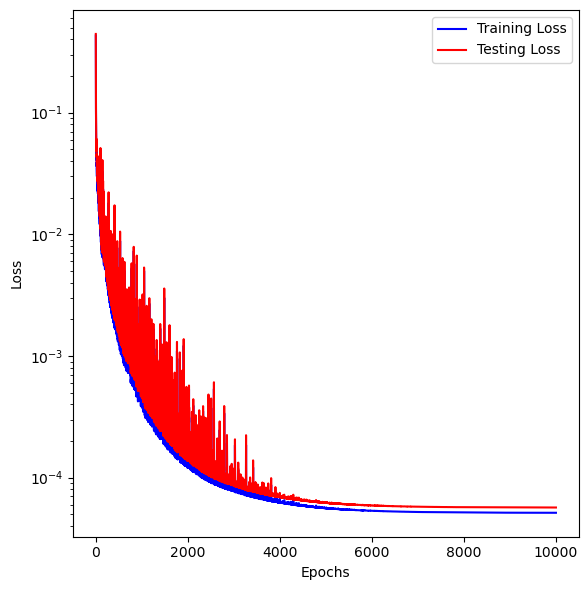

In [15]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(save_results_to+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [16]:
## alternatively, use class method to predict
test_out = test_data['y_out']
test_pred = model.predict(test_data)

print('test_out shape: {}, test_pred shape: {}'.format(test_out.shape, test_pred.shape))

error = np.linalg.norm(test_out - test_pred, axis = 1)/np.linalg.norm(test_out, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2397), test_pred shape: (100, 2397)
Num tests:   100, Mean Loss (rel l2): 9.047e-03, Std Loss (rel l2): 4.492e-03


i_plot =     0, error (rel l2): 5.291e-03
i_plot =     1, error (rel l2): 7.006e-03
i_plot =     2, error (rel l2): 1.129e-02
i_plot =     3, error (rel l2): 6.407e-03
i_plot =     4, error (rel l2): 2.618e-02
i_plot =     5, error (rel l2): 6.869e-03
i_plot =     6, error (rel l2): 1.070e-02
i_plot =     7, error (rel l2): 6.055e-03
i_plot =     8, error (rel l2): 6.199e-03
i_plot =     9, error (rel l2): 5.693e-03
i_plot =    10, error (rel l2): 2.647e-02
i_plot =    11, error (rel l2): 7.636e-03
i_plot =    12, error (rel l2): 6.168e-03
i_plot =    13, error (rel l2): 9.979e-03
i_plot =    14, error (rel l2): 5.986e-03
i_plot =    15, error (rel l2): 9.897e-03


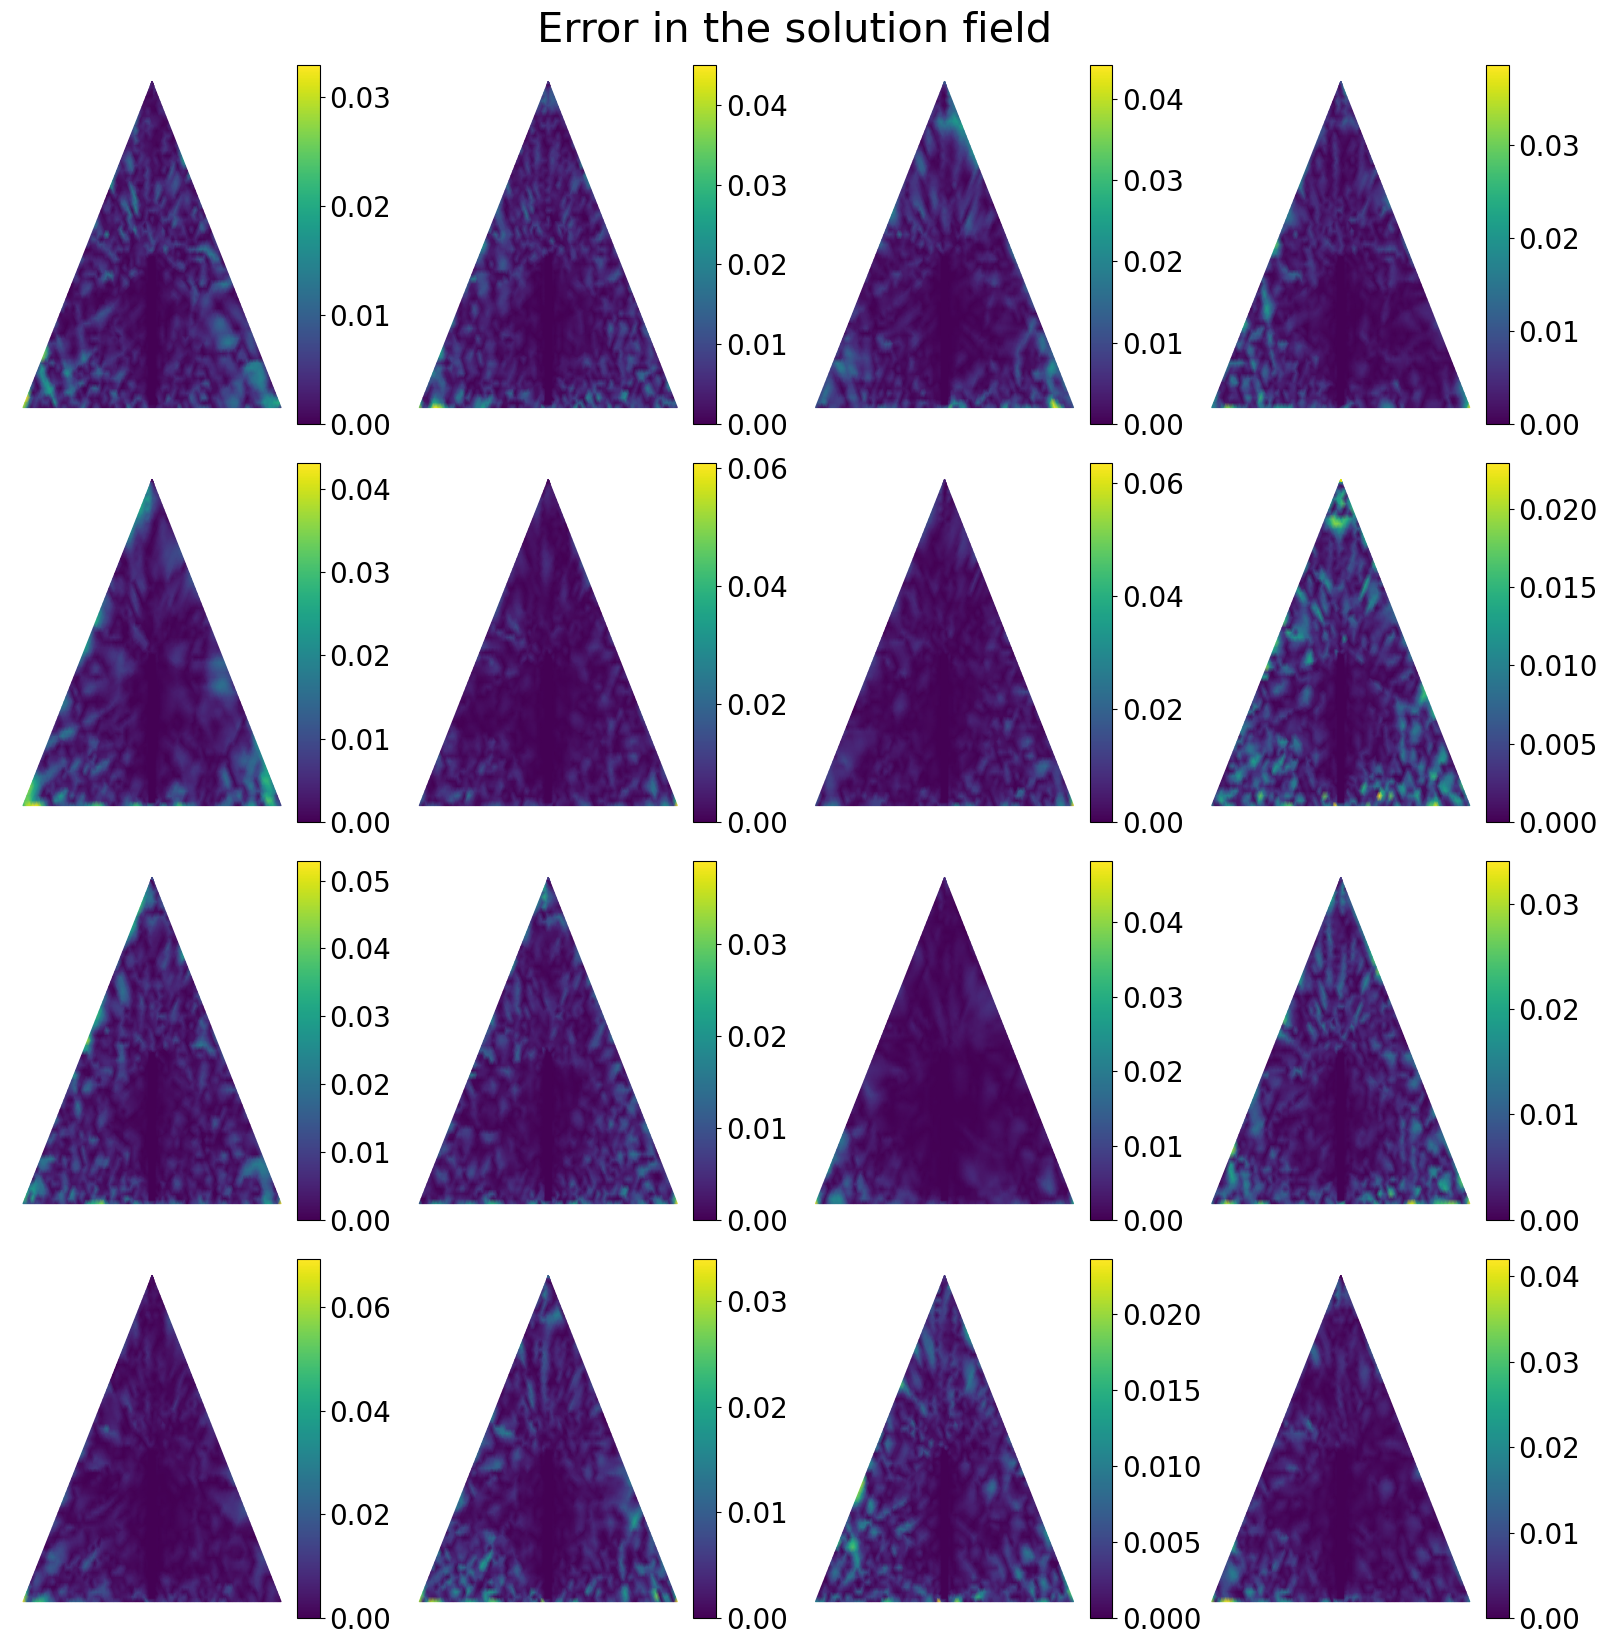

In [17]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))

decode = True

for i in range(rows):
    for j in range(cols):
        i_plot = i*cols + j

        i_pred = test_pred[i_plot, :]
        i_truth = test_out[i_plot, :]
        if decode:
            i_pred = out_decencoder.decoder(i_pred)
            i_truth = out_decencoder.decoder(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = X_trunk

        cbar = field_plot(axs[i,j], i_diff, nodes)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[j,i].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(save_results_to+'sample_error_plots.png',  bbox_inches='tight')
plt.show()
